# Frequency Sweep

This is set up to use these channels when you set outputChannel = 6 and inputChannel = 0

Output Channel 6 (DAC 229 CH2) --> Input Channel 0 (ADC 224 CH0)



In [1]:
import matplotlib.pyplot as plt

from pynq import Overlay
import numpy as np

from qsystem_2 import *
from qsystem2_asm import *

In [2]:
# Set the input and output channels
outputChannel = 6 # choose 1 through 7 here
inputChannel = 0 # choose 0 or 1 here

In [3]:
# Signal Generator V4.
# 31  ..   0 : frequency.
# 63  ..  32 : phase.
# 79  ..  64 : addr.
# 95  ..  80 : xxxx (not used).
# 111 ..  96 : gain.
# 127 .. 112 : xxxx (not used).
# 143 .. 128 : nsamp.
# 145 .. 144 : outsel  (00: product, 01: dds, 10: table, 11: zero value).
#        146 : mode    (0: nsamp, 1: periodic).
#        147 : stdysel (0: last value, 1: zero value).
#        148 : phrst   (not implemented yet).
# 159 .. 149 : xxxx (not used).

#ASM 2.0 for DDS Frequency Visualization
soc = PfbSoc('qsystem_2.bit', force_init_clks=False)
with ASM_Program() as p:
    #Write all memory addresses to program memory
    p.memri(0,1,0,"freq")
    p.memri(0,2,5,"gain")
    p.memri(0,3,2,"nsamp")
    #p.memri(1,7,1) # Set the readout frequency I believe this is depreciated. 
    p.memri(1,2,3,"Nsync")
    p.memri(1,3,4,"Loop")
    #Set up nsamp and DAC selection register. 
    p.regwi(0,4,0b0101,"0b1001, stdysel = 1 (zero value), mode = 0 (nsamp), outsel = 01 (dds).")
    p.bitwi(0,4,4, "<<", 16)
    p.bitw(0,3,3,"|",4)
    #Delay the start a bit
    p.synci(1000)
    #Trigger the average block. 
    p.regwi(1, 1, 0xC001)  
    p.seti(0,1,0,0) #Just set the triger to 0. 
    #p.set(4,0,1,0,0,2,3,0)
    #p.set(5,0,1,0,0,2,3,0)
    p.set(outputChannel,0,1,0,0,2,3,0) # The Output Channel
    #Loop
    p.label("LOOP")
    p.seti(0,1,1,0) #Trigger the readout
    
    p.seti(0,1,0,5) #Disable trigger 5 clocks later. 
    p.sync(1,2)
    p.loopnz(1,3,"LOOP")
    #End loop
    #Signal End
    p.seti(0, 1, 0, 0)
    p.end("all done")
soc.tproc.load_asm_program(p)

***Address Space***

<ol start="0">
    <li>Output Frequency (freq)</li>
    <li>DDS Readout Frequency </li>
    <li>Numer of Samples (nsamp)</li>
    <li>Sync Time (Nsync)</li>
    <li>Loop Iteration Count (Loop)</li>
    <li>Output Gain (gain)</li>
</ol>

In [22]:
#Sends a pulse at the given frequency (freq) for the given time (nsamp) with the given gain (gain)
#and reads back a signal from the average buffer that is 1.3 times the duration (nsamp). 
#This is repeated (loop) times. 

debugMode = False
enablePrintSignature = False
enablePrintBuffers = False
enablePrintAverages = False
enableTestFunction = False

def getAvgSamples (freq=150, gain=30000, nsamp=200, loop=50, outputType="product", adcChannel=0):
    
    gain = int(np.round(gain))
    if enablePrintSignature: 
        print(f"DAC/DDS Frequency: {freq}")
        print(f"ADC Gain: {gain}")
        print(f"Number of Samples: {nsamp}")
        print(f"Loop Count: {loop}")
        print(f"Input Type: {outputType}")
    
    #Set the address register space. 
    #Format the numbers and send them to the tproc for output frequency
    freqRegDAQ = freq2reg(soc.fs_dac, freq, B=32)
    soc.tproc.single_write(addr=0, data = freqRegDAQ)
    if debugMode: print(f"Output Frequency DAC: {freqRegDAQ}")
    #Format the nubmers and send them to the tproc for DDS frequency
    freqRegADC = freq2reg(soc.fs_adc, freq) #DDS is set to same freq as DAC
    soc.tproc.single_write(addr=1, data = freqRegADC)
    if debugMode: print(f"DDS Frequency: {freqRegADC}")
    #Simply write to the amp address WITHOUT formatting. (It is assumed that the user will do this)
    soc.tproc.single_write(addr=2, data = nsamp)
    if debugMode: print(f"nsamp: {nsamp}")
    #Write the size  of the pulse on the ADC domain (nSync). This is defined to be 1.3 times the duration (nsamp)
    nsync = int(nsamp * 1.3) #With no multiplier, there will be no delay between pulses. 
    soc.tproc.single_write(addr=3, data = nsync)
    if debugMode: print(f"nsync: {nsync}")
    #Write the loop iteration count (Loop). It should be noted that the loop iteration variable must be loopCount-1. 
    soc.tproc.single_write(addr=4, data = loop-1)
    if debugMode: print(f"loop: {loop}")
    #Write output gain WITHOUT formatting to the output gain address. 
    soc.tproc.single_write(addr=5, data = int(gain))
    if debugMode: print(f"gain: {gain}")
    
    #Set the size of the average buffer to nsamp (number of decimated samples) and enable the buffer. 
    soc.readouts[adcChannel].set_out(outputType)
    soc.readouts[adcChannel].set_freq(freq)
    #soc.avg_bufs[adcChannel].config(address = adcChannel, length = int(nsamp)) # Or should address=adcChannel???
    soc.avg_bufs[adcChannel].config(address = 0, length = int(nsamp)) # Or should address=adcChannel???
    soc.avg_bufs[adcChannel].enable()
    if debugMode: print(f"Average Buffer Length: {nsamp}")
    
    #Start tProc
    #soc.setSelection("product")
    soc.tproc.stop()
    soc.tproc.start()
    
    #Get I/Q decimated samples with the length loop * nsync where nsync is the number of decimated samples and 
    decimatedLength = loop * nsamp
    #idec,qdec = soc.get_decimated(ch=0, length = (loop) * nsamp)
    try:
        idec,qdec = soc.get_decimated(ch=adcChannel, length = decimatedLength)
        if enablePrintBuffers:

            #Plot everything. 
            fig,ax = plt.subplots(2, 1, sharex=True)
            ax[0].plot(idec)
            ax[0].set_ylabel("I")
            ax[1].plot(qdec)
            ax[1].set_ylabel("Q")
            ax[1].set_xlabel("Sample Number")
            ax[0].set_title("Decimated Samples")
    except RuntimeError as e:
        idec,qdec = None,None
        #print("Trouble reading decimated values",e)
        
    #Get I/Q accumulated samples with the number of loop iterations. 
    try:
        iacc,qacc =  soc.get_accumulated(ch=adcChannel, length=loop)
    except RuntimeError as e:
        iacc,qacc = None,None
        print("Trouble reading accumulated values",e)
    
    if enablePrintAverages: 
        #Get the absolute value of the I and Q values
        absValues = np.sqrt(iacc ** 2 + qacc ** 2)

        #Get the phase for each sample
        phases = np.arctan2(qacc, iacc)

        #Plot everything. 
        fig,ax = plt.subplots(4,1,sharex=True)
        ax[0].plot(iacc, "*-")
        ax[0].set_ylabel("I")
        ax[1].plot(qacc, "*-")
        ax[1].set_ylabel("Q")
        ax[2].plot(absValues, "*-")
        ax[2].set_ylabel("Abs Values")
        ax[3].set_xlabel("sample number")
        ax[3].plot(phases, "*-")
        ax[3].set_ylabel("Phases")
        ax[0].set_title("from getAccumulated")
        
    return idec, qdec, iacc, qacc

Text(0.5,0,'Gain')

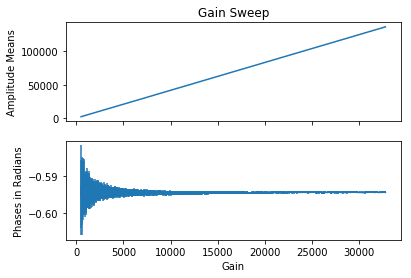

In [24]:
#Gain Sweep

gStart = 500
gStop = 32767
nGains = 1000
freq = 150

gains = np.linspace(gStart, gStop, nGains)
ampMeans = np.zeros(len(gains))
ampStds = np.zeros(len(gains))
phaseMeans = np.zeros(len(gains))
phaseStds = np.zeros(len(gains))

for i, g in enumerate(gains):
    idec,qdec,iacc,qacc = getAvgSamples(gain=g, freq=freq, adcChannel=inputChannel)
    amps = np.abs(iacc + 1j * qacc)
    phases = np.angle(iacc + 1j * qacc)
    ampMeans[i] = amps[2:].mean()
    ampStds[i] = amps[2:].std()
    phaseMeans[i] = phases[2:].mean()
    phaseStds[i] = phases[2:].std()

fig,ax = plt.subplots(2,1,sharex=True)
plt.xkcd
ax[0].set_title("Gain Sweep")
#ax[0].errorbar(gains, ampMeans, yerr=ampStds)
ax[0].plot(gains, ampMeans)
ax[0].set_ylabel("Amplitude Means")
ax[1].errorbar(gains, phaseMeans, yerr=phaseStds)
ax[1].set_ylabel("Phases in Radians")
plt.xlabel("Gain")

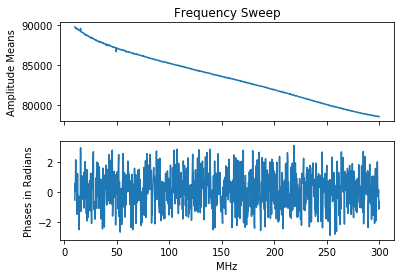

In [13]:
#Frequency Sweep

freqStart = 10 #MHz
freqStop = 300 #MHz
nFreqs = 1000
gain = 20000

freqs = np.linspace(freqStart, freqStop, nFreqs)
ampMeans = np.zeros(len(freqs))
ampStds = np.zeros(len(freqs))
phaseMeans = np.zeros(len(freqs))
phaseStds = np.zeros(len(freqs))

for i, f in enumerate(freqs):
    idec,qdec,iacc,qacc = getAvgSamples(freq=f, gain=gain, adcChannel=inputChannel)
    amps = np.abs(iacc + 1j * qacc)
    phases = np.angle(iacc + 1j * qacc)
    ampMeans[i] = amps[2:].mean()
    ampStds[i] = amps[2:].std()
    phaseMeans[i] = phases[2:].mean()
    phaseStds[i] = phases[2:].std()

fig,ax = plt.subplots(2,1,sharex=True)
ax[0].set_title("Frequency Sweep")
#ax[0].errorbar(freqs, ampMeans, yerr=ampStds)
ax[0].plot(freqs, ampMeans)
ax[0].set_ylabel("Amplitude Means")
#ax[1].errorbar(freqs, phaseMeans, yerr=phaseStds)
ax[1].plot(freqs, phaseMeans)
ax[1].set_ylabel("Phases in Radians")
plt.xlabel("MHz")
plt.show()